In [23]:
# Import libraries
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm.auto import trange
import numpy as np
import matplotlib.pyplot as plt
import generate_quantum_dataset as gqd
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [24]:
# Import datasets

# sep_data = th.load('../datasets/sep_states.pt')

# ent_data = th.load('../datasets/ent_states.pt')

N_states = 10000

# Generate N_states separable and entangled states
sep_data = th.tensor(gqd.generate_separable_states(10, N_states), dtype=th.complex64)
ent_data = th.tensor(gqd.generate_entangled_states(N_states), dtype=th.complex64)

th.save(sep_data, '../datasets/sep_states.pt')
th.save(ent_data, '../datasets/ent_states.pt')

In [25]:
# check if they are truly separable and entangled
print("Any entangled data in the separable dataset?: ", any(gqd.is_entangled(sep_data[i].numpy()) for i in range(N_states)))
print("Are all the data in the entangled dataset entangled?: ", all(gqd.is_entangled(ent_data[i].numpy()) for i in range(N_states)))

Any entangled data in the separable dataset?:  False
Are all the data in the entangled dataset entangled?:  True


In [26]:
data_len = len(sep_data)
full_data_sep = th.empty((data_len, 32))
full_data_ent = th.empty((data_len, 32))

for i in range(data_len):
    full_data_sep[i, :] = th.cat((sep_data[i].flatten(start_dim=0).real, sep_data[i].flatten(start_dim=0).imag), dim=0)
    full_data_ent[i, :] = th.cat((ent_data[i].flatten(start_dim=0).real, ent_data[i].flatten(start_dim=0).imag), dim=0)
    
full_data_ent.shape

torch.Size([10000, 32])

In [27]:
# scaler = StandardScaler()
# full_data_sep_norm = scaler.fit_transform(full_data_sep)
# full_data_ent_norm = scaler.fit_transform(full_data_ent)



In [28]:
BATCH_SIZE = 64

# create dataloaders
# sep_train_loader = DataLoader(th.tensor(full_data_sep_norm, dtype=th.float32), batch_size=BATCH_SIZE, shuffle=True)
# ent_train_loader = DataLoader(th.tensor(full_data_ent_norm, dtype=th.float32), batch_size=BATCH_SIZE, shuffle=True)

sep_train_loader = DataLoader(th.tensor(full_data_sep, dtype=th.float32), batch_size=BATCH_SIZE, shuffle=True)
ent_train_loader = DataLoader(th.tensor(full_data_ent, dtype=th.float32), batch_size=BATCH_SIZE, shuffle=True)

/var/folders/tg/s7bvn5_n5ngb3nrzxqsyqbyw0000gn/T/ipykernel_92512/1590196366.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sep_train_loader = DataLoader(th.tensor(full_data_sep, dtype=th.float32), batch_size=BATCH_SIZE, shuffle=True)
/var/folders/tg/s7bvn5_n5ngb3nrzxqsyqbyw0000gn/T/ipykernel_92512/1590196366.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ent_train_loader = DataLoader(th.tensor(full_data_ent, dtype=th.float32), batch_size=BATCH_SIZE, shuffle=True)


In [29]:
# do the same to create two test sets
N_states = 3000

sep_data = th.tensor(gqd.generate_separable_states(10, N_states), dtype=th.complex64)
ent_data = th.tensor(gqd.generate_entangled_states(N_states), dtype=th.complex64)

print("Any entangled data in the separable dataset?: ", any(gqd.is_entangled(sep_data[i].numpy()) for i in range(N_states)))
print("Are all the data in the entangled dataset entangled?: ", all(gqd.is_entangled(ent_data[i].numpy()) for i in range(N_states)))

# sep_data_pair = th.stack((sep_data.flatten(start_dim=1).real, sep_data.flatten(start_dim=1).imag), dim = 1)
# ent_data_pair = th.stack((ent_data.flatten(start_dim=1).real, ent_data.flatten(start_dim=1).imag), dim = 1)

full_data_sep = th.empty((N_states, 32))
full_data_ent = th.empty((N_states, 32))

for i in range(N_states):
    full_data_sep[i, :] = th.cat((sep_data[i].flatten(start_dim=0).real, sep_data[i].flatten(start_dim=0).imag), dim=0)
    full_data_ent[i, :] = th.cat((ent_data[i].flatten(start_dim=0).real, ent_data[i].flatten(start_dim=0).imag), dim=0)
    
scaler = StandardScaler()
full_data_sep_norm = scaler.fit_transform(full_data_sep)
full_data_ent_norm = scaler.fit_transform(full_data_ent)

# sep_test_loader = DataLoader(th.tensor(full_data_sep_norm, dtype=th.float32), batch_size=BATCH_SIZE, shuffle=True)
# ent_test_loader = DataLoader(th.tensor(full_data_ent_norm, dtype = th.float32), batch_size=BATCH_SIZE, shuffle=True)

sep_test_loader = DataLoader(th.tensor(full_data_sep, dtype=th.float32), batch_size=BATCH_SIZE, shuffle=True)
ent_test_loader = DataLoader(th.tensor(full_data_ent, dtype = th.float32), batch_size=BATCH_SIZE, shuffle=True)

Any entangled data in the separable dataset?:  False
Are all the data in the entangled dataset entangled?:  True


/var/folders/tg/s7bvn5_n5ngb3nrzxqsyqbyw0000gn/T/ipykernel_92512/3445670150.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sep_test_loader = DataLoader(th.tensor(full_data_sep, dtype=th.float32), batch_size=BATCH_SIZE, shuffle=True)
/var/folders/tg/s7bvn5_n5ngb3nrzxqsyqbyw0000gn/T/ipykernel_92512/3445670150.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ent_test_loader = DataLoader(th.tensor(full_data_ent, dtype = th.float32), batch_size=BATCH_SIZE, shuffle=True)


In [30]:
# define the model

class VAE_fc(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(VAE_fc, self).__init__()
        self.input_size = input_size
        self.enc1 = nn.Linear(input_size, hidden_size[0])
        self.enc2 = nn.Linear(hidden_size[0], hidden_size[1])
        self.enc_mu = nn.Linear(hidden_size[1], hidden_size[2])
        self.enc_logvar = nn.Linear(hidden_size[1], hidden_size[2])
        
        self.dec1 = nn.Linear(hidden_size[2], hidden_size[1])
        self.dec2 = nn.Linear(hidden_size[1], hidden_size[0])
        self.dec3 = nn.Linear(hidden_size[0], input_size)
        
        self.relu = nn.ReLU()
    
    def encoder(self, x):
        x = self.relu(self.enc1(x))
        x = self.relu(self.enc2(x))
        mu = self.enc_mu(x)
        logvar = self.enc_logvar(x)
        return mu, logvar
    
    def reparametrize(self, mu, logvar):
        std = th.exp(0.5*logvar)
        eps = th.randn_like(std)
        return mu + eps*std
    
    def decoder(self, z):
        z = self.relu(self.dec1(z))
        z = self.relu(self.dec2(z))
        z = self.relu(self.dec3(z))
        return z
    
    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparametrize(mu, logvar)
        decoded = self.decoder(z)
        return decoded, z, mu, logvar

In [31]:
# try the model

model = VAE_fc(input_size=32, hidden_size=[32, 16, 8])

for _, data in enumerate(sep_train_loader):
    print(data.shape)
    decoded, z, mu, logvar = model(data)
    print(decoded.shape, z.shape, mu.shape, logvar.shape)
    break

torch.Size([64, 32])
torch.Size([64, 32]) torch.Size([64, 8]) torch.Size([64, 8]) torch.Size([64, 8])


In [32]:
# Define the loss function
def loss_function(output, x, mu, logvar):
    recon_loss = F.mse_loss(output, x, reduction='sum')
    kl_loss = -0.5 * th.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + 0.5 * kl_loss

In [33]:
def train_model(model, train_loader, optimizer, criterion, epochs):
    
    train_loss = []
    for epoch in trange(epochs):
        epoch_loss = 0.0
        
        for _, data in enumerate(train_loader):
            optimizer.zero_grad()
            output, _, mu, logvar = model(data)
            loss = criterion(output, data, mu, logvar)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            
        epoch_loss /= len(train_loader.dataset)
        train_loss.append(epoch_loss)
        print("Epoch: {}, Loss: {}".format(epoch, epoch_loss))

    return model, train_loss

In [34]:
# Define constant parameters
HIDDEN_SIZE = [32, 16, 5]
EPOCHS = 15
LR = 0.001
INPUT_SIZE = 32

In [35]:
# Train separable VAE
model = VAE_fc(input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE)
optimizer = optim.Adam(model.parameters(), lr=LR)

sep_trained_model, sep_train_loss = train_model(model, sep_train_loader, optimizer, loss_function, EPOCHS)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0, Loss: 0.18674551862478256
Epoch: 1, Loss: 0.08215703065395355
Epoch: 2, Loss: 0.07992003471851349
Epoch: 3, Loss: 0.07939611854553223
Epoch: 4, Loss: 0.07918876549005509
Epoch: 5, Loss: 0.07906583173274993
Epoch: 6, Loss: 0.07902289354801179
Epoch: 7, Loss: 0.07898358438014984
Epoch: 8, Loss: 0.07894874218702316
Epoch: 9, Loss: 0.07894658150672913
Epoch: 10, Loss: 0.07893677874803542
Epoch: 11, Loss: 0.07891485786437988
Epoch: 12, Loss: 0.07892363661527634
Epoch: 13, Loss: 0.07896810318231583
Epoch: 14, Loss: 0.07891139831542969


In [36]:
# Train entangled VAE
model = VAE_fc(input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE)
optimizer = optim.Adam(model.parameters(), lr=LR)

ent_trained_model, ent_train_loss = train_model(model, ent_train_loader, optimizer, loss_function, EPOCHS)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0, Loss: 1.9700645992279053
Epoch: 1, Loss: 1.363541631126404
Epoch: 2, Loss: 1.3461869161605835
Epoch: 3, Loss: 1.3432214044570923
Epoch: 4, Loss: 1.3399471794128417
Epoch: 5, Loss: 1.3398733587265015
Epoch: 6, Loss: 1.3389584964752197
Epoch: 7, Loss: 1.3392171167373657
Epoch: 8, Loss: 1.3385029766082763
Epoch: 9, Loss: 1.3374430799484254
Epoch: 10, Loss: 1.3375758367538453
Epoch: 11, Loss: 1.337755694961548
Epoch: 12, Loss: 1.3372692953109742
Epoch: 13, Loss: 1.3370943809509277
Epoch: 14, Loss: 1.3376900466918946


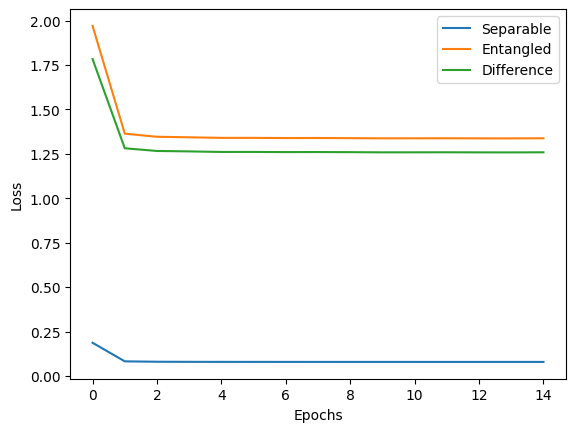

In [37]:
plt.plot(sep_train_loss, label='Separable')
plt.plot(ent_train_loss, label='Entangled')
plt.plot(np.abs(np.array(sep_train_loss) - np.array(ent_train_loss)), label='Difference')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.savefig('../Figures/training_losses.png')

In [38]:
# Calculate the reconstruction loss on the training sets, withouth the KL divergence term

loss_criterion = F.mse_loss

reconstruction_loss = np.ndarray((1, 2))

reconstruction_loss[:, 0] = loss_criterion(ent_trained_model(ent_train_loader.dataset)[0],
                                     ent_train_loader.dataset,
                                     reduction='sum').detach().numpy() / len(ent_train_loader.dataset)

reconstruction_loss[:, 1] =loss_criterion(sep_trained_model(sep_train_loader.dataset)[0],
                                     sep_train_loader.dataset,
                                     reduction='sum').detach().numpy() / len(sep_train_loader.dataset)

rec_loss = pd.DataFrame(reconstruction_loss, columns=['entangled', 'separable'])

rec_loss

,entangled,separable
0,1.336653,0.078921


In [39]:
# calculate the reconstruction loss on the test sets
test_loss = np.ndarray((2, 2))

for i, loader in enumerate([ent_test_loader, sep_test_loader]):
    for j, model in enumerate([ent_trained_model, sep_trained_model]):
        test_loss[i, j] = loss_criterion(model(loader.dataset)[0],
                                         loader.dataset,
                                         reduction='sum').detach().numpy() / len(loader.dataset)

test_loss    

array([[1.33771997, 3.2259681 ],
       [1.61711491, 0.07889077]])

In [40]:
test_losses = pd.DataFrame(test_loss, columns=['ent_model', 'sep_model'], index=['ent_set', 'sep_set'])

test_losses

,ent_model,sep_model
ent_set,1.337720,3.225968
sep_set,1.617115,0.078891


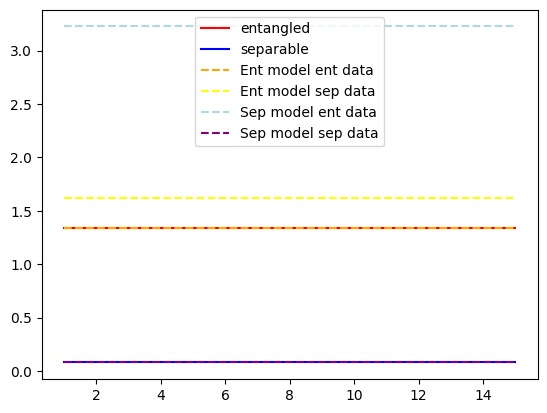

In [41]:
x_values = np.arange(1, EPOCHS + 1)
x_len = len(x_values)
plt.plot(x_values, rec_loss['entangled'][0] * np.ones(x_len) , label='entangled', color='red')
plt.plot(x_values, rec_loss['separable'][0] * np.ones(x_len), label='separable', color='blue')
plt.plot(x_values, test_losses["ent_model"]["ent_set"] * np.ones(x_len), label='Ent model ent data', linestyle='--', color = 'orange')
plt.plot(x_values, test_losses["ent_model"]["sep_set"] * np.ones(x_len), label='Ent model sep data', linestyle='--', color = 'yellow')
plt.plot(x_values, test_losses["sep_model"]["ent_set"] * np.ones(x_len), label='Sep model ent data', linestyle='--', color = 'lightblue')
plt.plot(x_values, test_losses["sep_model"]["sep_set"] * np.ones(x_len), label='Sep model sep data', linestyle='--', color = 'purple')
plt.legend()

plt.savefig('../Figures/reconstruction_losses.png')